# Детекция объектов VOC2012 (YOLOv5) — lite версия

## Клонирование репозитория и импорт библиотек

In [2]:
# !git clone https://github.com/ultralytics/yolov5
# !cd yolov5
# !pip install -r /content/yolov5/requirements.txt

In [4]:
# !pip install squarify

In [24]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing

# Для работы с изображениями и построения модели
import torch
import cv2
import shutil
from sklearn.model_selection import train_test_split
import squarify
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Загрузка данных

In [6]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

In [7]:
# Путь до папки с датасетом
DATASET_PATH = "/content/VOCdevkit/VOC2012"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "JPEGImages")

# Функция для парсинга xml-файлов
def xml_to_csv(path = ANNOTATIONS_PATH):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            name = obj.find('name').text

            value = (root.find('filename').text,
                     width, height, name,
                     xmin, ymin, xmax, ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'name', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [8]:
xml_df = xml_to_csv()
print('Конвертация прошла успешно.')

100%|██████████| 3503/3503 [00:00<00:00, 8439.16it/s]

Конвертация прошла успешно.


In [9]:
print(f'Количество записей об объектах {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Количество записей об объектах 7760
Количество изображений в датафрэйме 3503


Мы собираемся изъять всего 100 изображений для наших выборок и рискуем получить дисбаланс классов и проблему с репрезентативностью. Чтобы избежать как минимум второго негативного момента, нам нужно провести некоторые промежуточные манипуляции.

## Обработка данных

Закодируем классы обьектов.

In [10]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['name'])

xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,class
0,2010_006675.jpg,500,375,person,1,146,166,375,14
1,2010_005670.jpg,375,500,person,310,125,375,423,14
2,2010_005670.jpg,375,500,bicycle,80,121,340,483,1
3,2010_005670.jpg,375,500,bicycle,1,66,91,353,1
4,2010_005670.jpg,375,500,bicycle,34,1,258,112,1


Сохраним кодировку классов в переменной mapping.

In [11]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))
class_id_to_name_mapping

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

In [12]:
grouped_xml_df = xml_df.groupby('filename').agg({'name': 'unique', 'class': pd.Series.mode}).reset_index()

grouped_xml_df['single_class'] = grouped_xml_df['class'].apply(lambda x: x[0] if type(x) == np.ndarray else x)
grouped_xml_df['mode_name'] = grouped_xml_df['single_class'].map(class_id_to_name_mapping)
grouped_xml_df.head()

,filename,name,class,single_class,mode_name
0,2010_000001.jpg,"[cat, chair, diningtable]",8,8,chair
1,2010_000002.jpg,[sheep],16,16,sheep
2,2010_000003.jpg,"[dog, chair]","[8, 11]",8,chair
3,2010_000009.jpg,[cat],7,7,cat
4,2010_000014.jpg,[dog],11,11,dog


## Визуализация данных и проверка модели

Напишем функцию для визуализации. Функция будет принимать название файла с нужным изображением и DataFrame с координатами и выводить изображение на экран.

In [13]:
def plot_bounding_box(image_folder, image_filename, df=xml_df):
    # Создаем полный путь до изображения
    image_path = os.path.join(image_folder, image_filename)
    # Читаем изображение
    img = plt.imread(image_path)
    # Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize=(10, 8))
    # Выводим изображение на экран
    ax.imshow(img);

    # Находим индекс картинки в DataFrame
    image_idx = df[df['filename'] == image_filename].index

    # Так как боксов может быть несколько, создаем цикл по всем ним
    for i in range(len(image_idx)):
        # Находим координаты левой нижней точки
        x_min = df.loc[image_idx[i], 'xmin']
        y_min = df.loc[image_idx[i], 'ymin']
        # Находим ширину и высоту рамки
        box_width = df.loc[image_idx[i], 'xmax'] - df.loc[image_idx[i], 'xmin']
        box_height = df.loc[image_idx[i], 'ymax'] - df.loc[image_idx[i], 'ymin']
        name = df.loc[image_idx[i], 'name']
        # Строим прямоугольник
        rect = patches.Rectangle(
            (x_min, y_min),  # Координаты опорной точки
            box_width,  # Ширина прямоугольника
            box_height,  # Высота прямоугольника
            linewidth=1.5,  # Ширина линии
            edgecolor=(0, 1, 0),  # Цвет
            facecolor='none'  # Заливка (none - отсутствует)
        )
        # Добавляем прямоугольник на изображение
        ax.add_patch(rect)
        ((text_width, text_height), _) = cv2.getTextSize(
            name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
        text_rect = patches.Rectangle(
            (x_min, y_min - 2 - int(1.3 * text_height)),
            text_width * 1.1,
            text_height * 1.5,
            linewidth=0,
            edgecolor=(0, 1, 0),
            facecolor=(0, 1, 0)
        )
        ax.add_patch(text_rect)

        # Добавляем текстовую метку (name) к прямоугольнику
        ax.text(
            x_min, y_min - 2,
            name, color='w', fontsize=12
        )

    plt.show()

2010_003731.jpg


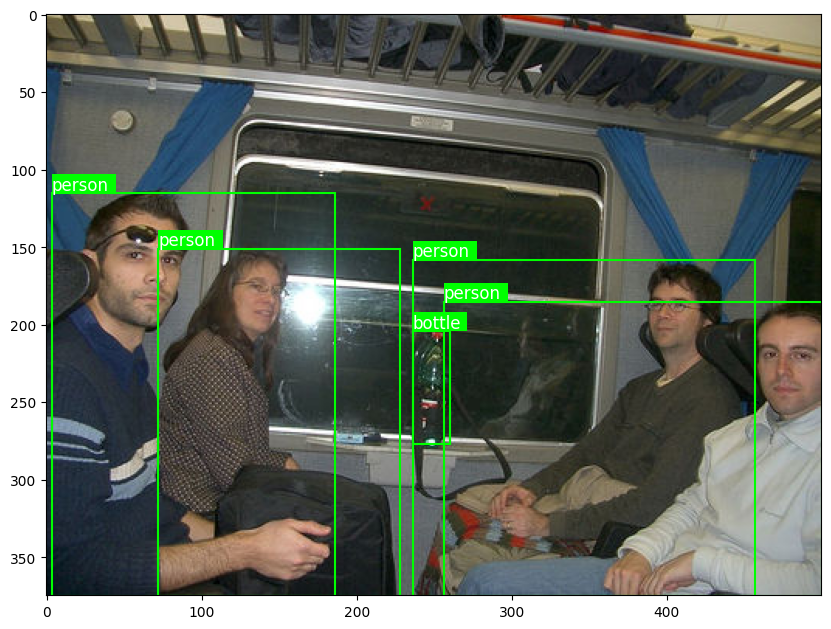

In [14]:
# Выберем рандомное фото и выведем его с рамками
random_image_filename = np.random.choice(xml_df.filename.unique())
print(random_image_filename)
plot_bounding_box(IMAGES_PATH, random_image_filename)

Обученная модель находится в классе hub библиотеки `torch`.

Посмотрим на предсказания модели для нашей рандомной картинки.

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-6-5 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 387MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
WAR

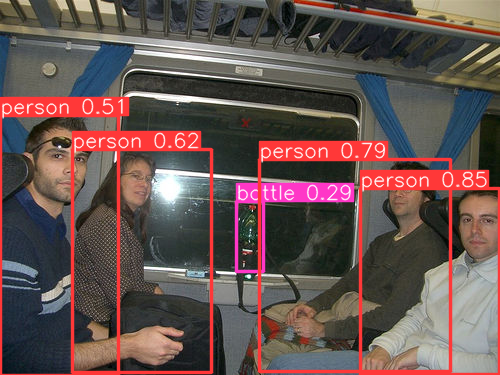

In [15]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

image_path = os.path.join(IMAGES_PATH, random_image_filename)

# Inference
results = model(image_path)

# Results
results.print()
results.show()

Чтобы иметь возможность оценить способности модели, выведем строки с информацией об объектах, котрые мы спарсили с xml-ки фото.

In [16]:
xml_df.loc[xml_df['filename'].isin([random_image_filename])]

,filename,width,height,name,xmin,ymin,xmax,ymax,class
2304,2010_003731.jpg,500,375,person,3,115,186,375,14
2305,2010_003731.jpg,500,375,person,72,151,228,375,14
2306,2010_003731.jpg,500,375,person,236,158,457,375,14
2307,2010_003731.jpg,500,375,person,256,185,500,375,14
2308,2010_003731.jpg,500,375,bottle,236,204,260,277,4


## Формируем датасет

Мы будем обучать модель **yolov5**. Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Перейдем к созданию директорий. Зададим пути в виде глобальных переменных:

In [17]:
DATA_PATH = "dataset/"

LABELS_PATH = os.path.join(DATA_PATH, "labels")
IMGS_PATH = os.path.join(DATA_PATH, "images")

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train")
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val")
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train")
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val")

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml")

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

dataset/images/train
dataset/images/val
dataset/labels/train
dataset/labels/val
dataset/dataset.yaml


Теперь создадим необходимые нам директории.


In [18]:
# Создаем локальную папку, в которую будем складывать изображения
# и аннотации к ним (если таковой еще не существует)
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Создаем папку, где будем хранить тренировочные изображения
# (если такая еще не существует)
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)
# Создаем папку, где будем хранить тренировочные аннотации к объектам
# (если такая еще не существует)
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)

# Создаем папку, где будем хранить валидационные изображения
# (если такая еще не существует)
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)

# Создаем папку, где будем хранить валидационные аннотации к объектам
# (если такая еще не существует)
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

Добавим файл конфигурации данных, назовем его - dataset.yaml, в нем пропишем все пути.

In [19]:
names = '\n    '.join(
    [f'{k}: {v}' for k, v in class_id_to_name_mapping.items()]
)

# Создаем содержимое файла
data_config = f'''
path: /content/dataset
train: images/train
val: images/val
test:
names:
    {names}
'''

# Открываем на запись файл, куда записываем конфигурацию путей,
# откуда будут браться данные для обучения
with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

# Проверим, что все записалось корректно
with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: /content/dataset
train: images/train
val: images/val
test:
names:
    0: aeroplane
    1: bicycle
    2: bird
    3: boat
    4: bottle
    5: bus
    6: car
    7: cat
    8: chair
    9: cow
    10: diningtable
    11: dog
    12: horse
    13: motorbike
    14: person
    15: pottedplant
    16: sheep
    17: sofa
    18: train
    19: tvmonitor



Разделим все множество доступных нам изображении на два в соотношении 80/20.

In [20]:
train, valid, _, _ = train_test_split(
    grouped_xml_df, grouped_xml_df.single_class,
    test_size=20, train_size=80,
    random_state=42, shuffle=True,
    stratify=grouped_xml_df.single_class
)

# Посмотрим на размеры выборок
print('Train shape: {}'.format(len(train)))
print('Validation shape: {}'.format(len(valid)))

Train shape: 80
Validation shape: 20


In [21]:
train_df = xml_df[xml_df['filename'].isin(list(train.filename))]
train_df.to_csv('train_df.csv', index=None)
valid_df = xml_df[xml_df['filename'].isin(list(valid.filename))]
valid_df.to_csv('valid_df.csv', index=None)

xml_df_lite = pd.concat([train_df, valid_df])

Так что там с балансом классов?

In [22]:
print(f'Общее количество объектов в train {train_df.shape[0]}')
print(f'Общее количество объектов в valid {valid_df.shape[0]}')

Общее количество объектов в train 178
Общее количество объектов в valid 39


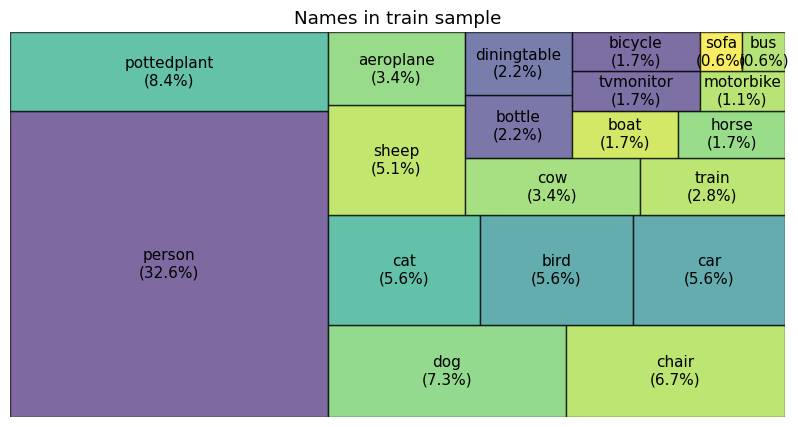

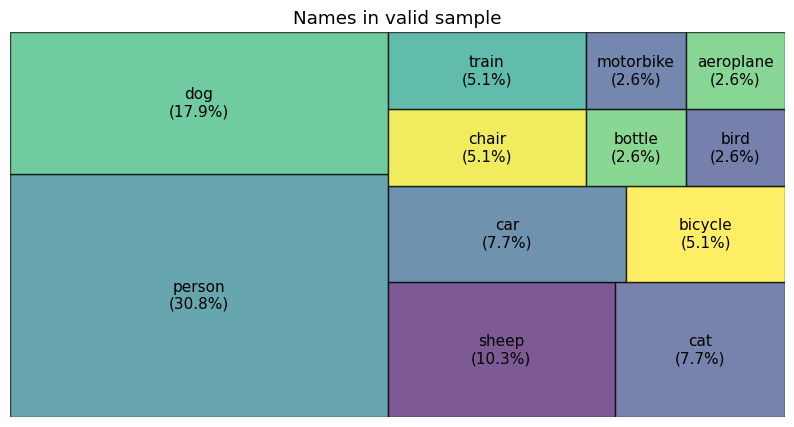

In [26]:
# Получаем распределение значений столбца 'name' с нормализацией
train_names_vls_cnts = train_df['name'].value_counts(normalize=True)
valid_names_vls_cnts = valid_df['name'].value_counts(normalize=True)

# Функция для получения иерархической диаграммы
def get_hierarchical_diagram(vls_cnts, sample='train'):
    plt.figure(figsize=(10, 5))
    squarify.plot(
        sizes=vls_cnts,
        label=[f'{label}\n({value:.1%})' for label, value in zip(
            vls_cnts.index, vls_cnts
            )],
        alpha=0.7, edgecolor='black')
    plt.axis('off')
    plt.title(f'Names in {sample} sample')
    plt.show()

for vls_cnts, sample_name in [(train_names_vls_cnts, 'train'), (valid_names_vls_cnts, 'valid')]:
    get_hierarchical_diagram(vls_cnts, sample=sample_name)

С изображениями разобрались – осталось лишь скопировать их в папки. Файлы же с аннотациями предстоит еще создать. Дополним для этого наш датафрейм необходимой информацией: сформируем четыре новых столбца – координаты центра рамки, ее ширина и высота.



In [27]:
# Вычисляем нормализованные координаты центра ограничивающей рамки
xml_df_lite['x_center'] = (xml_df_lite['xmin'] + xml_df_lite['xmax']) / (2 * xml_df_lite['width'])
xml_df_lite['y_center'] = (xml_df_lite['ymin'] + xml_df_lite['ymax']) / (2 * xml_df_lite['height'])

# Вычисляем относительную высоту и ширину ограничивающей рамки
xml_df_lite['box_width'] = (xml_df_lite['xmax'] - xml_df_lite['xmin']).abs() / xml_df_lite['width']
xml_df_lite['box_height'] = (xml_df_lite['ymax'] - xml_df_lite['ymin']).abs() / xml_df_lite['height']

# Посмотрим на результаты
xml_df_lite[['class','x_center','y_center','box_width','box_height']].head()

,class,x_center,y_center,box_width,box_height
132,2,0.402667,0.535,0.288000,0.090
133,2,0.058667,0.312,0.112000,0.064
134,2,0.536000,0.414,0.149333,0.052
135,2,0.513333,0.294,0.114667,0.052
136,2,0.772000,0.371,0.306667,0.106


Наконец, заполним наши папки:
* папки с аннотациями заполним txt-файлами с форматом данных;
* папки с изображениями заполним изображениями из соответствующих выборок.

In [28]:
# Создаем цикл по изображениям
for filename, mini in tqdm(xml_df_lite.groupby('filename')):
    # Если текущий файл находится в валидационной выборке
    if filename in list(valid.filename):
        path2save = 'val'
    # В противном случае (тренировочная выборка)
    else:
        path2save = 'train'
    # Составляем путь до файла, куда запишем новую аннотацию
    new_annotation_path = os.path.join(LABELS_PATH, path2save, filename[:-4] + ".txt")
    # Открываем на запись с добавлением (w+) файл формата .txt
    with open(new_annotation_path, 'w+') as f:
        # Выделяем координаты bounding box в формате, требуемым для YOLOv5
        row = mini[['class','x_center','y_center','box_width','box_height']].astype(float).values
        row = row.astype(str)
        # Построчно записываем координаты каждого из bounding box на изображении
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
    # Переносим в новую папку изображения из исходной папки
    shutil.copy(
        os.path.join(IMAGES_PATH, filename),
        os.path.join(IMGS_PATH, path2save, filename)
    )


100%|██████████| 100/100 [00:00<00:00, 741.46it/s]


Проверим файлы

In [29]:
print(sorted(os.listdir(TRAIN_LABELS_PATH))[:5])
print(sorted(os.listdir(TRAIN_IMAGES_PATH))[:5])

['2010_000054.txt', '2010_000436.txt', '2010_000458.txt', '2010_000470.txt', '2010_000534.txt']
['2010_000054.jpg', '2010_000436.jpg', '2010_000458.jpg', '2010_000470.jpg', '2010_000534.jpg']


Посмотрим, как выглядят наши аннотации, на примере выбранного файла:

2010_000534.jpg
18.0 0.551 0.3228228228228228 0.078 0.14714714714714713
14.0 0.158 0.5465465465465466 0.072 0.15615615615615616
14.0 0.279 0.4084084084084084 0.038 0.11411411411411411
14.0 0.336 0.3483483483483483 0.016 0.07807807807807808
14.0 0.36 0.35285285285285284 0.02 0.07507507507507508
14.0 0.387 0.3408408408408408 0.022 0.06906906906906907
14.0 0.642 0.32882882882882886 0.02 0.06906906906906907
14.0 0.614 0.3138138138138138 0.02 0.05105105105105105



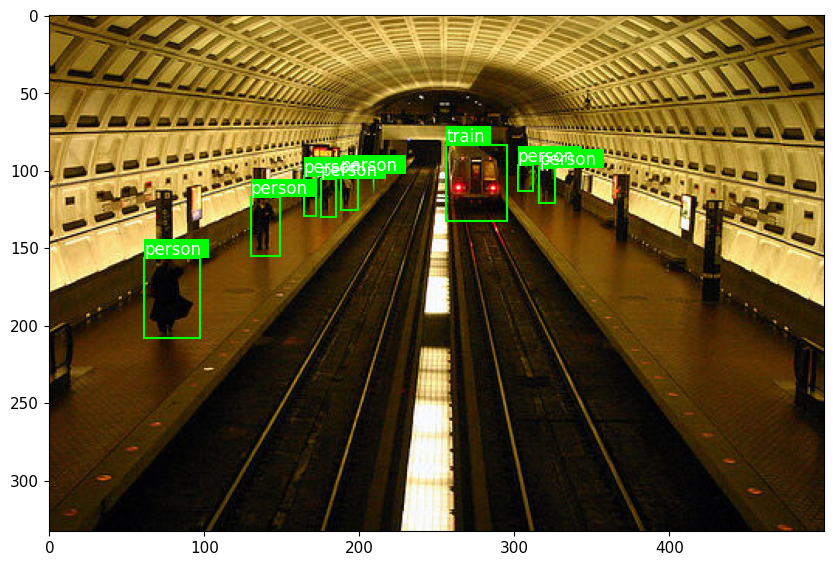

In [31]:
# Выберем рандомное фото и выведем его с рамками
img_name = np.random.choice(xml_df_lite.filename.unique())
print(img_name)

# Откроем файл с аннотацией и прочитаем содержимое
with open(
    os.path.join(
        TRAIN_LABELS_PATH,
        img_name.replace("jpg", "txt")
        )
    ) as f:
    txt_example = f.read()
# Выведем содержимое на экран
print(txt_example)

# Посмотрим на то, как выглядит сама картинка
plot_bounding_box(TRAIN_IMAGES_PATH, img_name)

Проверим, что количество аннотаций совпадает с количеством изображений:

In [32]:
# Проверим, что количество аннотаций совпадает с количество изображений в каждой выборке
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


## Строим модель детекции

In [33]:
!ls yolov5

benchmarks.py	 data	     LICENSE	     README.zh-CN.md   tutorial.ipynb
CITATION.cff	 detect.py   models	     requirements.txt  utils
classify	 export.py   pyproject.toml  segment	       val.py
CONTRIBUTING.md  hubconf.py  README.md	     train.py


Зафиксируем датчик генератора случайных чисел, чтобы в дальнейшем получать воспроизводимые результаты. Для этого в репозитории yolov5 в модуле utils.general есть функция init_seeds(), в которую нужно передать любое число. Чтобы корректно вызвать эту функцию необходимо перейти в директорию yolov5 и вызвать функцию, находясь в ней. Для перемещения между директориями воспользуемся функцией [os.chdir()](https://docs-python.ru/standart-library/modul-os-python/funktsija-chdir-modulja-os/) из модуля os.

По традиции в качестве random_state возьмем 42. После фиксации всех генераторов случайных чисел вернемся в исходную рабочую директорию.

In [34]:
# Перемещаемся в директорию yolov5
os.chdir('yolov5')
# Импортируем оттуда функцию init_seeds
from utils.general import init_seeds
#Фиксируем генератор случайных чисел для воспроизводимости результатов
RANDOM_STATE = 42
init_seeds(RANDOM_STATE)
# Возвращаемся обратно в рабочую директорию
os.chdir('../')

Для сохранения процесса обучения воспользуемся инструментом Weights&Bias. Авторизуемся через анонимный аккаунт.

In [35]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 kB 32.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Обучаем модель

Теперь мы можем воспользоваться модель и дообучить ее под нашу задачу.

Для обучения модели в репозитории yolov5 предназначен скрипт train.py. Для его запуска необходимо указать следующие ключи:

* `--img` - размер изображения, подаваемого на вход YOLOv5. Это значит, что размер исходного изображения преобразуется к виду $n x n$, где $n$ — число, введенное пользователем после ключа —img;

    **Важно:**
    $n$ должно быть кратно 32 (это связано с архитектурой YOLOv5). 32 в данном случае - это размер одного сегмента, о котором мы говорили, когда обсуждали общую идею работы YOLO.
* `--batch` - размер батча, то есть число картинок, подаваемых в сеть за один шаг обучения;
* `--epochs` - количество эпох обучения, задает сколько раз датасет будет пропущен через нейронную сеть для ее обучения;
* `--data` - путь до файла формата .yaml, который мы создавали выше;
* `--weights` - предобученные веса, используемые моделью;
* `--name` - имя папки, куда сохраняем результаты обучения.

Ключ `--weights` отвечает за выбор предобученной модели.

In [36]:
# Запускаем файл train.py со скриптом для обучения модели

!python yolov5/train.py \
--img 512 \
--batch 8 \
--epochs 60 \
--data {DATA_CONFIG_PATH} \
--weights yolov5s.pt \
--name my_yolov5_model_s

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-05 11:13:43.303506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 11:13:43.303579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 11:13:43.422742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: anony-mouse-385646040366419709. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=dataset/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low

### Валидируем модель

In [37]:
!ls yolov5/runs/train/my_yolov5_model_s/

confusion_matrix.png				    P_curve.png       train_batch2.jpg
events.out.tfevents.1717586033.b33e0f9ae2b0.2668.0  PR_curve.png      val_batch0_labels.jpg
F1_curve.png					    R_curve.png       val_batch0_pred.jpg
hyp.yaml					    results.csv       val_batch1_labels.jpg
labels_correlogram.jpg				    results.png       val_batch1_pred.jpg
labels.jpg					    train_batch0.jpg  weights
opt.yaml					    train_batch1.jpg


Посмотрим на графики, наиболее общая информация, представляющая для нас интерес содержится в файле results.png.

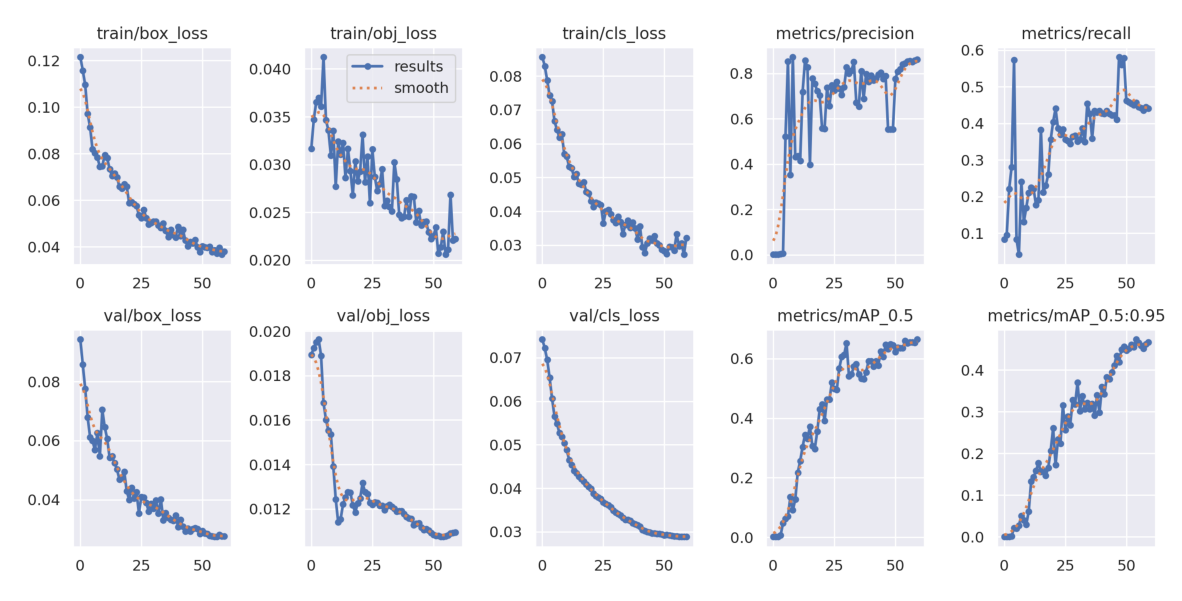

In [38]:
# Читаем файл с графиками процесса обучения
results = plt.imread('/content/yolov5/runs/train/my_yolov5_model_s/results.png')
# Отображаем графики
fig, ax = plt.subplots(figsize=(15,12))
ax.axis('off')
ax.imshow(results);

В папке runs/result/weights хранятся 2 файла с весами (параметрами нейронной сети):
* best.pt — файл, в котором сохранен лучший вариант параметров модели за все время обучения
* last.pt — файл, в котором сохранены веса, которые модель получила на последней эпохе обучения

In [39]:
!ls yolov5/runs/train/my_yolov5_model_s/weights

best.pt  last.pt


Загрузим наилучшие веса в нашу модель.


In [40]:
# Путь до места, где хранятся лучшие веса
BEST_WEIGHTS_PATH = '/content/yolov5/runs/train/my_yolov5_model_s/weights/best.pt'
# Загружаем лучшие веса
yolov5 = torch.hub.load(
    repo_or_dir='yolov5',
    model='custom',
    path=BEST_WEIGHTS_PATH,
    source='local'
)
# Понизим порог допустимой уверенности модели
yolov5.conf = 0.00

YOLOv5 🚀 2024-6-5 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


Проверим работу нашей лучшей модели, возьмем какую-нибудь картинку и подадим ее на вход модели.

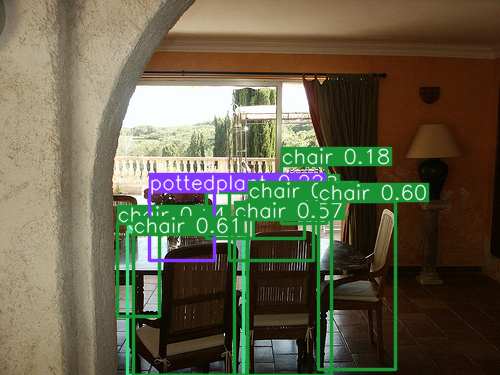

In [41]:
# Путь до изображения
image_filename = '2010_000463.jpg'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем картинку через модель
yolov5.conf = 0.1
prediction = yolov5(image_path)
# Отображаем результат
prediction.show()

2010_004825.jpg


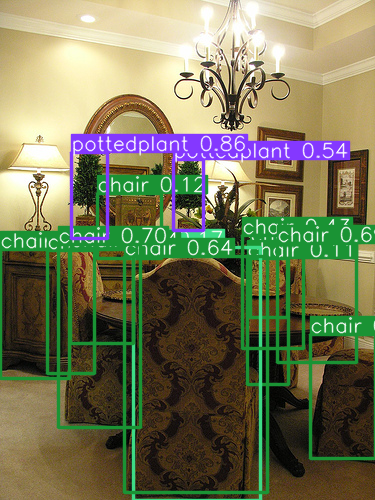

In [42]:
# Выберем рандомное фото и выведем его с рамками
random_image_idx = np.random.choice(xml_df_lite.reset_index().shape[0])
image_filename = xml_df_lite.reset_index().loc[random_image_idx, 'filename']
print(image_filename)
# Путь до изображения
image_path = os.path.join(IMAGES_PATH, image_filename)
# Пропускаем картинку через модель
prediction = yolov5(image_path)
# Отображаем результат
prediction.show()

Пробежимся по всем фото и сделаем предсказания.

In [43]:
yolov5.conf = 0.01
# Список всех файлов с изображениями
filenames = xml_df_lite['filename']
# Создаем пустой DataFrame
preds_df = pd.DataFrame()
# Создаем цикл по всем файлами
for filename in tqdm(filenames):
    # Составляем путь до изображения
    image_path = os.path.join(IMAGES_PATH, filename)
    # Пропускаем изображение через модель
    prediction = yolov5(image_path)
    # Конвертируем предсказания в DataFrame
    pred_rows = prediction.pandas().xyxy[0]
    # Добавляем в DataFrame столбец с именем файла для ясности
    pred_rows['filename'] = filename
    # Конкатенируем полученный DataFrame к общей таблице
    preds_df = pd.concat([preds_df, pred_rows])

# Сбрасываем индекс
preds_df = preds_df.reset_index(drop=True)
preds_df.head()

100%|██████████| 217/217 [00:04<00:00, 50.95it/s]


,xmin,ymin,xmax,ymax,confidence,class,name,filename
0,98.846458,249.529770,205.550385,289.457062,0.689472,2,bird,2010_003659.jpg
1,167.083008,135.161057,215.744095,163.708221,0.610910,2,bird,2010_003659.jpg
2,165.728271,190.003067,225.773148,222.405243,0.513254,2,bird,2010_003659.jpg
3,1.601610,136.921127,42.758656,170.533386,0.469978,2,bird,2010_003659.jpg
4,295.425262,187.575684,375.000000,245.007751,0.453990,2,bird,2010_003659.jpg


In [44]:
print('Исходное число изображений:              ', xml_df_lite.filename.nunique())
print('Число изображений в таблице предсказаний:', preds_df.filename.nunique())
print('Число обнаруженных объектов:             ', preds_df.shape[0])

Исходное число изображений:               100
Число изображений в таблице предсказаний: 100
Число обнаруженных объектов:              3920


In [45]:
print('Max confidence:', preds_df.confidence.max())
print('Min confidence:', preds_df.confidence.min())

Max confidence: 0.895692765712738
Min confidence: 0.010008826851844788


Разделим таблицу с предсказаниями на два других согласно выборкам – треннировочному и валидационному.

In [46]:
# Отбираем предсказания для треннировочной выборки
train_preds_df = preds_df[preds_df['filename'].isin(list(train.filename))]

# Отбираем предсказания для валидационной выборки
val_preds_df = preds_df[preds_df['filename'].isin(list(valid.filename))]

Сохраним DataFrame с предсказанными координатами bounding box-ов, чтобы впоследствии проанализировать результаты.

In [47]:
#Сохраняем полученные предсказания в виде таблицы
train_preds_df.to_csv('/content/dataset/yolov5_train_predictions_lite.csv', index=False)
val_preds_df.to_csv('/content/dataset/yolov5_val_predictions_lite.csv', index=False)

## Считаем accuracy

In [48]:
# Функция для рассчета площади пересечения двух прямоугольников
def calculate_iou(box1, box2):
    x_left = max(box1['xmin'], box2['xmin'])
    y_top = max(box1['ymin'], box2['ymin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = min(box1['ymax'], box2['ymax'])

    if x_right < x_left or y_bottom < y_top:
        return 0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou


def calculate_detection_accuracy(
    true_df=None, preds=None,
    iou_threshold=0.5, confidence_threshold=0.25,
    get_report=False
    ):
    total_objects = len(true_df)
    correct_objects = 0
    true_val_cnts_dct = dict(true_df.name.value_counts())
    pred_val_cnts_dct = {key: 0 for key in list(true_val_cnts_dct.keys())}

    for filename in list(true_df.filename.unique()):
        true_boxes = true_df[true_df['filename'] == filename]
        pred_boxes = preds[preds['filename'] == filename]

        for _, true_row in true_boxes.iterrows():
            detected = [0]
            valid_box = {
                'xmin': true_row['xmin'],
                'ymin': true_row['ymin'],
                'xmax': true_row['xmax'],
                'ymax': true_row['ymax']
            }
            true_class = true_row['name']
            for _, pred_row in pred_boxes.iterrows():
                confidence = pred_row['confidence']
                if confidence >= confidence_threshold:
                    pred_box = {
                        'xmin': pred_row['xmin'],
                        'ymin': pred_row['ymin'],
                        'xmax': pred_row['xmax'],
                        'ymax': pred_row['ymax']
                    }
                    pred_class = pred_row['name']

                    iou = calculate_iou(pred_box, valid_box)
                    if iou >= iou_threshold:
                        if pred_class == true_class:
                            detected.append(1)

            correct_objects += max(detected)
            pred_val_cnts_dct[true_class] += max(detected)

    accuracy = correct_objects / total_objects
    if get_report:
        print('Class name: |  Acc:  |true:|pred:|')
        print('-'*34)
        for k, v in true_val_cnts_dct.items():
            detected_cnt = pred_val_cnts_dct[k]
            print(
                f'{k}'.ljust(11), f'| {detected_cnt/v:.4f} | {v}'.ljust(14),
                f'| {detected_cnt}'.ljust(5), '|')
        print('-'*34)
        print(f'Total Accuracy: {accuracy:.4f}')
    else:
        return accuracy

Можем построить поверхность accuracy при различных значениях IoU и уверенности модели.

In [49]:
iou_thresholds = np.arange(0.01, 1.11, 0.1)
confidence_thresholds = np.arange(0.01, 1.11, 0.1)
params_with_accuracy_lst = []

for i in tqdm(range(len(iou_thresholds))):

    for j in range(len(confidence_thresholds)):
        acc = calculate_detection_accuracy(
            true_df=valid_df, preds=val_preds_df,
            iou_threshold=iou_thresholds[i],
            confidence_threshold=confidence_thresholds[j]
            )

        params_with_accuracy_lst.append([
            iou_thresholds[i], confidence_thresholds[j], acc
            ])

iou, confidence, accuracy = [], [], []

# Разбиваем список списков на три списка
for sublist in params_with_accuracy_lst:
    iou.append(sublist[0])
    confidence.append(sublist[1])
    accuracy.append(sublist[2])

100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


In [50]:
df = pd.DataFrame(
    data=params_with_accuracy_lst,
    columns=['IoU', 'Confidence', 'Accuracy']
)
fig = px.scatter_3d(
    df, x='IoU',
    y='Confidence',
    z='Accuracy')
fig.show()

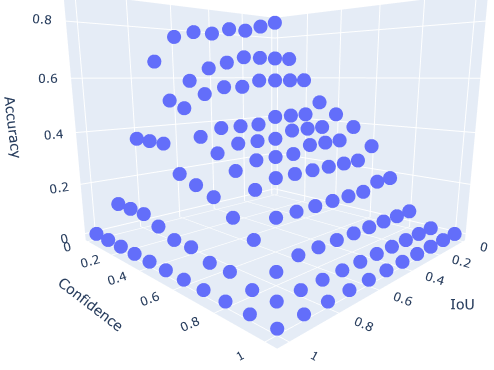

In [51]:
iou, conf = 0.51, 0.01
print(f'Report for IoU: {iou}; Confidence: {conf}')
calculate_detection_accuracy(
    valid_df, val_preds_df,
    iou_threshold=iou,
    confidence_threshold=conf,
    get_report=True
)

Report for IoU: 0.51; Confidence: 0.01
Class name: |  Acc:  |true:|pred:|
----------------------------------
person      | 0.9167 | 12  | 11  |
dog         | 0.5714 | 7   | 4   |
sheep       | 1.0000 | 4   | 4   |
cat         | 1.0000 | 3   | 3   |
car         | 1.0000 | 3   | 3   |
bicycle     | 0.5000 | 2   | 1   |
chair       | 1.0000 | 2   | 2   |
train       | 0.0000 | 2   | 0   |
bottle      | 1.0000 | 1   | 1   |
bird        | 1.0000 | 1   | 1   |
motorbike   | 0.0000 | 1   | 0   |
aeroplane   | 1.0000 | 1   | 1   |
----------------------------------
Total Accuracy: 0.7949


---
## Сравнение текущей модели с Faster RCNN по скорости и качетсву.

Модель на YOLOv5, очевидно, быстрее, что позволяет обучать ее на куда большем числе эпох, и порой благодаря этому добиваться сопоставимого качества за меньшее время.

[Ссылка на тетрадку с Faster RCNN](https://github.com/khav-i/nn_works/blob/master/Object%20detection%20VOC2012%20(Faster%20RCNN)/od_VOC2012_Faster_RCNN.ipynb).